In [1]:
from signal_utils import *

In [2]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class RFProcessingConfig:
    N: int
    F: float
    delay_kernel: List[float]
    i_delta: float
    q_delta: float
    osr: int
    AdB: float
    Fmax: float
    cpp_path: str
    quant_type: str
    LUT: List[List[int]]
    dtype: str
    plotShow: bool

In [3]:
def plotFigure(x, x_range, title="", AdB=None, freq_factor=None, y_range=None):
    freqs, xfftdB, angle = fftdB(x, win=True)
    if freq_factor:
        freqs *= freq_factor
    xmin = x_range[0]
    xmax = x_range[1]
    plt.title(title)
    plt.plot(freqs, xfftdB)
    if AdB:
        plt.plot([xmin, xmax], [-AdB, -AdB], '--r')
    plt.xlim([xmin, xmax])
    if y_range:
        plt.ylim([y_range[0], y_range[1]])
    plt.xlabel("f/fs")
    plt.ylabel("|X|dB")
    plt.grid()
    plt.show();   

def process_all(x: np.ndarray, config: RFProcessingConfig) -> np.ndarray:
    lut_width = len(config.lut[0])
    xi = x.real
    xq = x.imag

    if config.testShow:
        x_range = [-0.5, 0.5]
        plotFigure(x, x_range, title=f"Test Signal", AdB=None)

    # Taylor 1st Order Delay
    i_delta = 1/lut_width * 1/config.osr * config.i_delay_delta
    q_delta = 1/lut_width * 1/config.osr * config.q_delay_delta

    xi_delay = frac_delay_1st(xi, i_delta, config.delay_kernel)
    xq_delay = frac_delay_1st(xq, q_delta, config.delay_kernel)
    x_delay = xi_delay + 1j*xq_delay

    if config.delayShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_delay, x_range, title=f"Delayed Signal", AdB=None)

    # Interpolation
    deltaPass = 10**(-config.AdB_osr/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [config.Fmax, 1-config.Fmax]

    xi_osr = np.real(interpolate(xi_delay, config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq_delay, config.osr, F_interpolation, delta_interpolation, show=False, prt=False))
    x_osr = xi_osr + 1j*xq_osr

    if config.osrShow:
        x_range = [-0.5, 0.5]
        plotFigure(x_osr, x_range, freq_factor=1, title=f"Interpolated Signal, OSR = {osr}, AdB = {config.AdB_osr}", AdB=config.AdB_osr)

    # Delta-Sigma Modulation
    tmp = 4/np.max(np.abs(x_osr))
    xi_osr *= tmp
    xq_osr *= tmp

    # Delta-Sigma modulation
    xi_in_path = "./data/serial/xi_in.txt"
    xq_in_path = "./data/serial/xq_in.txt"
    xi_out_path = "./data/serial/xi_out.txt"
    xq_out_path = "./data/serial/xq_out.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"
    
    np.savetxt(xi_in_path, xi_osr, fmt="%.18e")
    np.savetxt(xq_in_path, xq_osr, fmt="%.18e")

    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
    
    xi_deltaSigma = np.loadtxt(xi_out_path)
    xq_deltaSigma = np.loadtxt(xq_out_path)
    x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma 

    if config.deltaSigmaShow:
        x_range = np.array([-0.5, 0.5])
        plotFigure(x_deltaSigma, x_range, title=f"Delta-Sigma Moudlated Signal", AdB=None)

    # Serialization
    xi_1b = convert_1b_optimized(xi_deltaSigma, config.lut, config.quant_type)
    xq_1b = convert_1b_optimized(xq_deltaSigma, config.lut, config.quant_type)
    x_1b = xi_1b + 1j*xq_1b

    # tmp = np.mean(x_1b)

    if config.serialShow:
        x_range = np.array([-0.5, 0.5]) / lut_width
        # x_1b -= tmp
        plotFigure(x_1b, x_range, title=f"Serialized Signal", AdB=None)

    # RFIQ
    # tmp = np.abs(tmp)
    x_rfiq = rfiq(xi_1b, xq_1b)

    if config.rfiqShow:
        x_range = 1 + np.array([-0.5, 0.5]) / lut_width
        plotFigure(x_rfiq, x_range, title=f"Reconstructed RF Signal", AdB=None, freq_factor=4, y_range=[-150, 5])

    return x_rfiq

def process(x, config):
    N = config.N
    n = np.arange(N)
    F = config.F
    i_delta = config.i_delta #1/8 * 1/32*1/8
    q_delta = config.q_delta #-1/8 * 1/32*1/8
    
    AdB = config.AdB
    perc = 0.15
    Fmax = config.Fmax
    
    # xi = 1.0 * np.cos(2*np.pi*F*n)
    # xq = 1.0 * np.sin(2*np.pi*F*n)
    # x = xi + 1j*xq

    if config.dtype == "true-shift":
        # True Fractional Shift
        xi_shift = 1.0 * np.cos(2*np.pi*F*(n-i_delta))
        xq_shift = 1.0 * np.sin(2*np.pi*F*(n-q_delta))
    elif config.dtype == "taylor-shift":
        xi = x[0]
        xq = x[1]
        xi_shift = frac_delay_1st(xi, i_delta, config.delay_kernel)
        xq_shift = frac_delay_1st(xq, q_delta, config.delay_kernel)
    elif config.dtype == "no-shift":
        xi_shift = x[0]
        xq_shift = x[1]
    
    # Interpolation
    deltaPass = 10**(-AdB/20)
    deltaStop = deltaPass
    delta_interpolation = [deltaPass, deltaStop]
    F_interpolation = [Fmax, 1-Fmax]
    xi_osr = np.real(interpolate(xi_shift, 8, F_interpolation, delta_interpolation, show=False, prt=False))
    xq_osr = np.real(interpolate(xq_shift, 8, F_interpolation, delta_interpolation, show=False, prt=False))
    
    # Delta-Sigma modulation
    factor = 4/np.max(np.abs(xi_osr + 1j*xq_osr))
    xi_osr *= factor
    xq_osr *= factor
    quant_type = config.quant_type
    cpp_path = config.cpp_path
    xi_in_path = "./data/serial/xi_in.txt"
    xq_in_path = "./data/serial/xq_in.txt"
    xi_out_path = "./data/serial/xi_out.txt"
    xq_out_path = "./data/serial/xq_out.txt"
    iir_path = "../data/input/deltaSigma_iirs.txt"
    np.savetxt(xi_in_path, xi_osr, fmt="%.18e")
    np.savetxt(xq_in_path, xq_osr, fmt="%.18e")
    subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, quant_type])  # Call the C++ program with input and output file paths as arguments
    xi_deltaSigma = np.loadtxt(xi_out_path)
    xq_deltaSigma = np.loadtxt(xq_out_path)
    
    # Serialization
    LUT = config.LUT
    xi_1b = convert_1b_optimized(xi_deltaSigma, LUT, quant_type)
    xq_1b = convert_1b_optimized(xq_deltaSigma, LUT, quant_type)
    
    # RFIQ
    x_rfiq = rfiq(xi_1b, xq_1b)
    

    if config.plotShow:
        x_delay_true = xi_shift + 1j*xq_shift
        x_osr = xi_osr + 1j*xq_osr
        x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma
        x_1b = xi_1b + 1j*xq_1b
        
        xrange = np.array([-.5, .5])
        # plotFigure(x, xrange)
        plotFigure(x_delay_true, xrange)
        plotFigure(x_osr, xrange, AdB=AdB)
        plotFigure(x_deltaSigma, xrange)
        plotFigure(x_1b, xrange/len(LUT[0]))
        plotFigure(x_rfiq, xrange/len(LUT[0])+1, freq_factor=4, y_range=[-150,5])
        # plotFigure(x_rfiq, xrange/len(LUT[0])/8+1, freq_factor=4, y_range=[-150,5])

    return x_rfiq
    

def find_SNR(x, f_range, bandwidth=0.005):
    freqs, spectrum_dB, _ = fftdB(x)
    freqs *= 4  # or whatever scaling is correct for your freq axis

    f_low, f_high = f_range

    # 1. Get frequency range of interest
    idx_band = np.where((freqs >= f_low) & (freqs <= f_high))[0]
    freqs_band = freqs[idx_band]
    spectrum_band = spectrum_dB[idx_band]

    # 2. Find peak index (signal)
    idx_peak_local = np.argmax(spectrum_band)
    peak_freq = freqs_band[idx_peak_local]
    signal_level = spectrum_band[idx_peak_local]

    # 3. Exclude bins around the peak
    idx_exclude_local = np.where(
        (freqs_band >= peak_freq - bandwidth) &
        (freqs_band <= peak_freq + bandwidth)
    )[0]

    # 4. Keep only noise bins
    idx_noise_local = np.setdiff1d(np.arange(len(freqs_band)), idx_exclude_local)

    if len(idx_noise_local) == 0:
        raise ValueError("No noise bins left after excluding signal.")

    noise_floor = np.max(spectrum_band[idx_noise_local])

    return signal_level - noise_floor


In [4]:
k3 = np.array([0.5, 0.0, -0.5])
k5 = np.array([-1, 8, 0, -8, +1]) / 12.0
k7 = np.array([1, -9, +45, 0, -45, +9, -1]) / 60.0
k9 = np.array([-1, 12, -39, +56, 0, -56, +39, -12, +1]) / 280.0

0.425


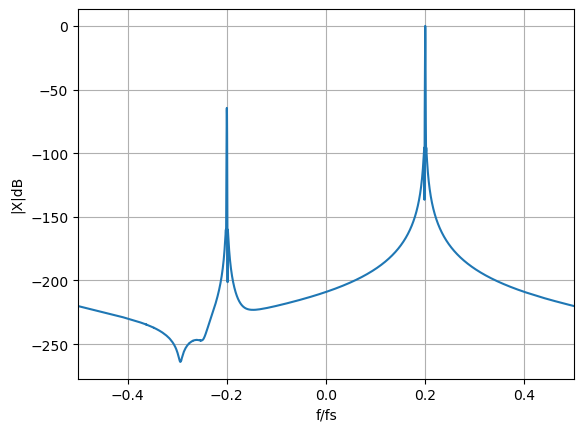

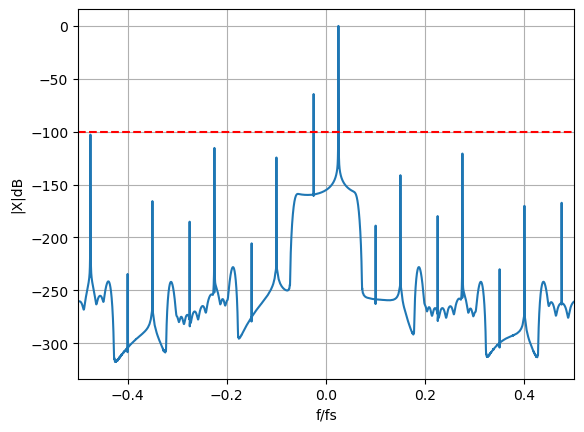

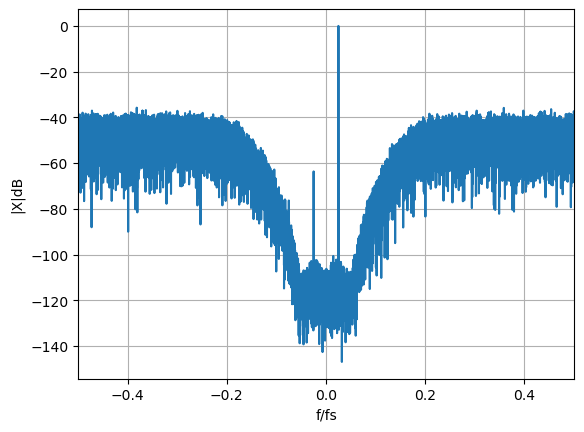

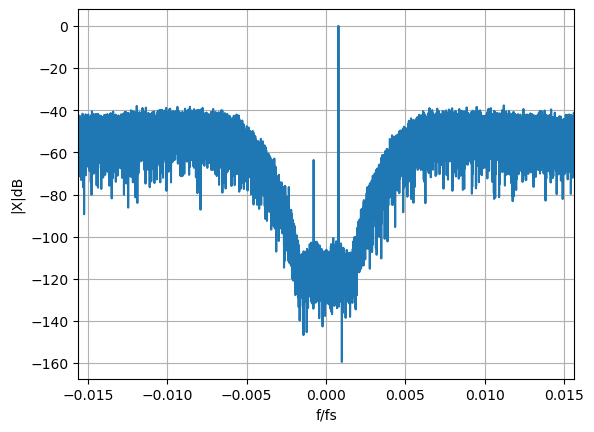

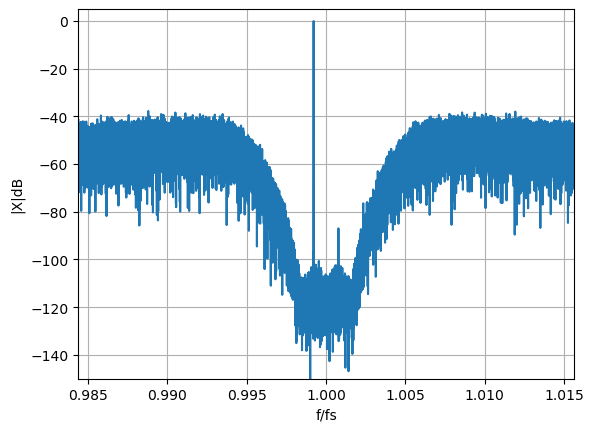

SNR = 87.04662448368182


In [6]:
cpp_path = "../build/delta-sigma" #"../build/delta-sigma"
quant_type = 'mid-tread'
LUT = LUT3

N = 2**12
n = np.arange(N)
perc = 0.15
Fmax = 0.5 * (1 - perc)
print(Fmax)

i_delta = -1/8 * 1/8 * 1/len(LUT[0])
q_delta = 1/8 * 1/8 * 1/len(LUT[0])

F = 0.2
xi = 1.0*np.cos(2*np.pi*F*n)
xq = 1.0*np.sin(2*np.pi*F*n)
x = [xi, xq]

config = RFProcessingConfig(
    N = N,
    F = F,
    delay_kernel = k7,
    i_delta = i_delta,
    q_delta = q_delta,
    osr = 8,
    AdB = 100,
    Fmax = Fmax,
    cpp_path = cpp_path,
    quant_type = quant_type,
    LUT = LUT,
    dtype = "taylor-shift",
    plotShow = True,
)

x_rfiq = process(x, config)

factor = 0.5 / len(LUT[0]) / 8
bandwidth = 0.1 / len(LUT[0]) / 8
f_range = [1 - factor, 1 + factor]
snr = find_SNR(x_rfiq, f_range=f_range, bandwidth=bandwidth)
print(f"SNR = {snr}")

In [7]:
cpp_path = "../build/delta-sigma" #"../build/delta-sigma"
quant_type = 'mid-tread'
LUT = LUT3

N = 2**12
n = np.arange(N)
perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

osr = 8
i_delta = -1/8 * 1/osr * 1/len(LUT[0])
q_delta = 1/8 * 1/osr * 1/len(LUT[0])

config = RFProcessingConfig(
    N = N,
    F = 0,
    delay_kernel = k7,
    i_delta = i_delta,
    q_delta = q_delta,
    osr = osr,
    AdB = 100,
    Fmax = Fmax,
    cpp_path = cpp_path,
    quant_type = quant_type,
    LUT = LUT,
    dtype = "taylor-shift",
    plotShow = False,
)

F = np.linspace(0.001, Fmax-0.01, 1024)
dtype_a = np.array(["no-shift", "taylor-shift"])
SNR = np.zeros((dtype_a.size, F.size))

total = len(dtype_a) * len(F)
counter = 0

for i, dtype in enumerate(dtype_a):
    config.dtype = dtype
    for j, f in enumerate(F):
        xi = 1.0 * np.cos(2 * np.pi * f * n)
        xq = 1.0 * np.sin(2 * np.pi * f * n)
        x = [xi, xq]

        config.F = f
        x_rfiq = process(x, config)

        factor = len(LUT[0]) * osr
        bandwidth = 0.1 / factor
        f_range = [1 - 0.5 / factor, 1 + 0.5 / factor]
        snr = -find_SNR(x_rfiq, f_range=f_range, bandwidth=bandwidth)
        SNR[i, j] = snr

        counter += 1
        print(f"Progress: {counter}/{total} ({100 * counter / total:.1f}%)", end='\r')

Fmax = 0.425
Progress: 2048/2048 (100.0%)

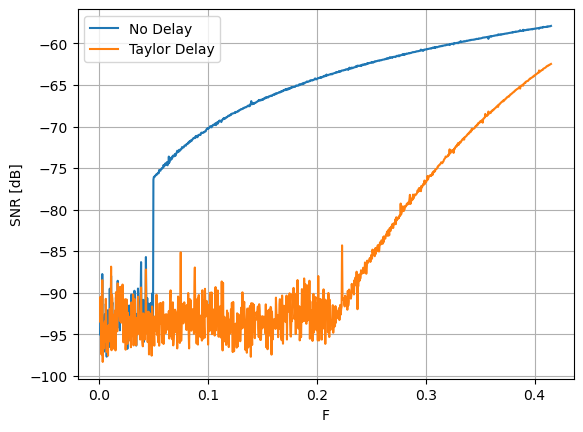

In [8]:
plt.figure()
plt.plot(F, SNR[0], label="No Delay")
plt.plot(F, SNR[1], label="Taylor Delay")
plt.legend()
plt.xlabel("F")
plt.ylabel("SNR [dB]")
plt.grid()
plt.savefig("snr.png")
plt.show()

NameError: name 'delta' is not defined

In [16]:
Fs = np.linspace(0.001, Fmax, N)
config.plotShow=False

SNR = []
for F in Fs:
    config.F = F
    xi = 1.0*np.cos(2*np.pi*F*n)
    xq = 1.0*np.sin(2*np.pi*F*n)
    x = [xi, xq]
    x_rfiq = process(x, config)
    
    factor = 0.5 / len(LUT[0]) / 8
    bandwidth = 0.1 / len(LUT[0]) / 8
    f_range = [1 - factor, 1 + factor]
    snr = find_SNR(x_rfiq, f_range=f_range, bandwidth=bandwidth)
    SNR.append(snr)
SNR = np.array(SNR)

KeyboardInterrupt: 

In [18]:
print(len(SNR))
print(len(Fs))

480
2049


In [20]:
SNR = np.array(SNR)*-1

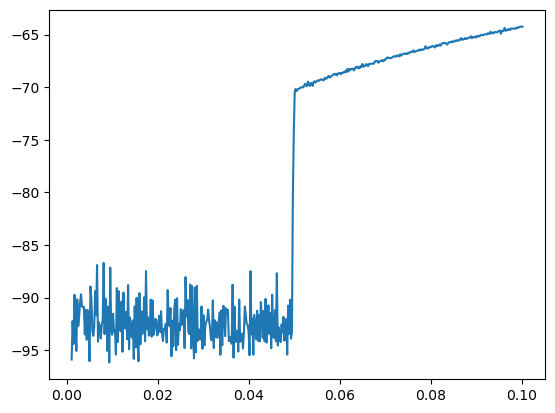

In [23]:
plt.plot(Fs[:len(SNR)], SNR)

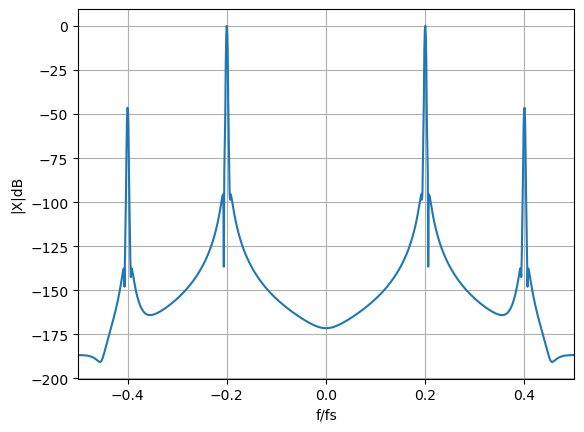

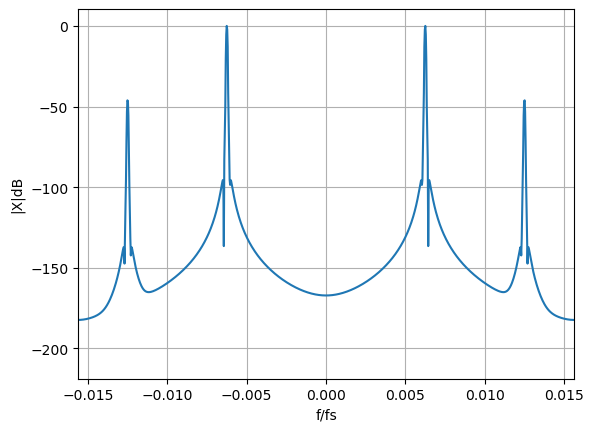

In [165]:
x = 1.0 * np.sin(2*np.pi*0.2*np.arange(1024))
x *= 8
x = np.round(x)
# print(x)
x_1b = convert_1b_optimized(x, LUT3, "mid-tread")
x_1b = [float(val) for val in x_1b]

plotFigure(x, np.array([-0.5, 0.5]))
plotFigure(x_1b, np.array([-0.5, 0.5])/32)

In [27]:
cpp_path = "../build/delta-sigma" #"../build/delta-sigma"
quant_type = 'mid-tread'
xi_in_path = "./data/serial/xi_in.txt"
xq_in_path = "./data/serial/xq_in.txt"
xi_out_path = "./data/serial/xi_out.txt"
xq_out_path = "./data/serial/xq_out.txt"
iir_path = "../data/input/deltaSigma_iirs.txt"
LUT = LUT3

0.425


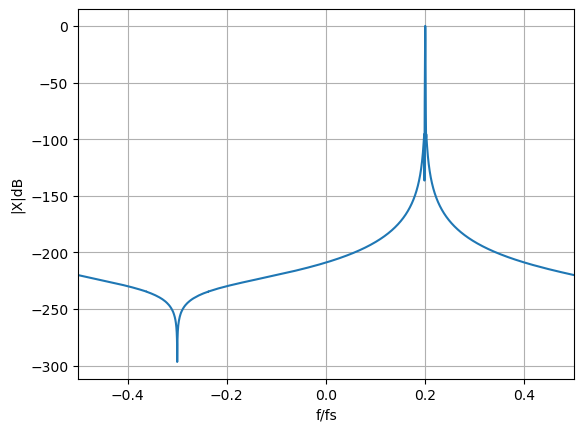

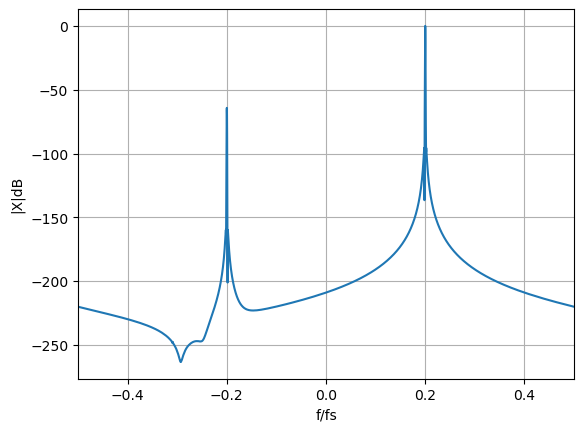

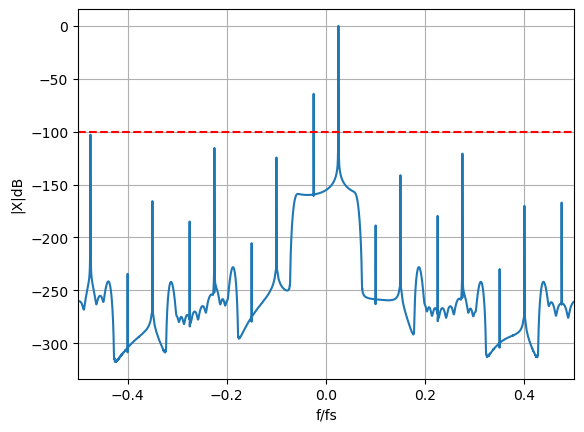

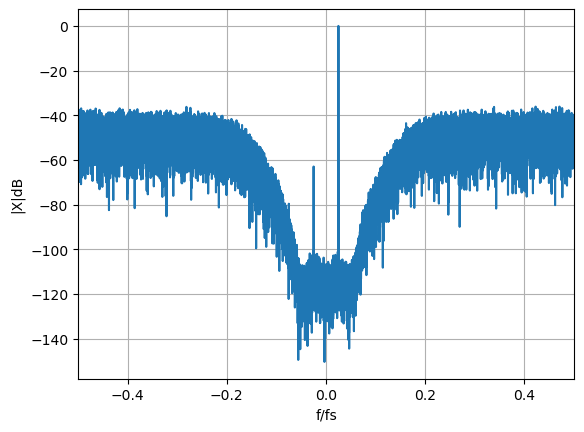

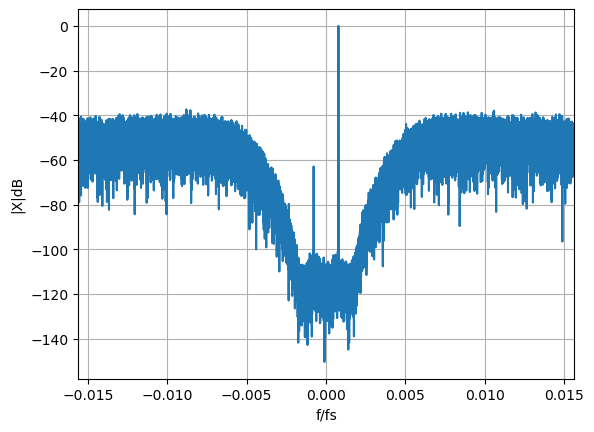

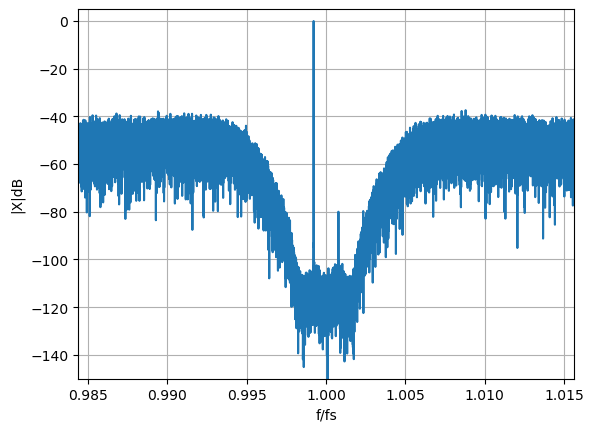

In [29]:
N = 2**12
n = np.arange(N)
F = 0.2 #100/N
i_delta = 1/8 * 1/32*1/8
q_delta = -1/8 * 1/32*1/8

AdB = 100
perc = 0.15
Fmax = 0.5 * (1 - perc)
print(Fmax)

xi = 1.0 * np.cos(2*np.pi*F*n)
xq = 1.0 * np.sin(2*np.pi*F*n)
x = xi + 1j*xq

# True Fractional Shift
xi_shift_true = 1.0 * np.cos(2*np.pi*F*(n-i_delta))
xq_shift_true = 1.0 * np.sin(2*np.pi*F*(n-q_delta))
x_delay_true = xi_shift_true + 1j*xq_shift_true

# Interpolation
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass
delta_interpolation = [deltaPass, deltaStop]
F_interpolation = [Fmax, 1-Fmax]
xi_osr = np.real(interpolate(xi_shift_true, 8, F_interpolation, delta_interpolation, show=False, prt=False))
xq_osr = np.real(interpolate(xq_shift_true, 8, F_interpolation, delta_interpolation, show=False, prt=False))
x_osr = xi_osr + 1j*xq_osr

# Delta-Sigma modulation
factor = 4/np.max(np.abs(x_osr))
xi_osr *= factor
xq_osr *= factor
np.savetxt(xi_in_path, xi_osr, fmt="%.18e")
np.savetxt(xq_in_path, xq_osr, fmt="%.18e")
subprocess.run([cpp_path, xi_in_path, xq_in_path, xi_out_path, xq_out_path, iir_path, config.quant_type])  # Call the C++ program with input and output file paths as arguments
xi_deltaSigma = np.loadtxt(xi_out_path)
xq_deltaSigma = np.loadtxt(xq_out_path)
x_deltaSigma = xi_deltaSigma + 1j*xq_deltaSigma

# Serialization
xi_1b = convert_1b_optimized(xi_deltaSigma, LUT, quant_type)
xq_1b = convert_1b_optimized(xq_deltaSigma, LUT, quant_type)
x_1b = xi_1b + 1j*xq_1b

# RFIQ
x_rfiq = rfiq(xi_1b, xq_1b)


xrange = np.array([-.5, .5])
plotFigure(x, xrange)
plotFigure(x_delay_true, xrange)
plotFigure(x_osr, xrange, AdB=AdB)
plotFigure(x_deltaSigma, xrange)
plotFigure(x_1b, xrange/len(LUT[0]))
plotFigure(x_rfiq, xrange/len(LUT[0])+1, freq_factor=4, y_range=[-150,5])